## 四跨连续箱梁桥 OpenSeesPy 建模 Notebook



In [219]:
# 参数面板：集中管理几何、材料、支承、记录与分析参数
# 参考：Model Commands — https://openseespydoc.readthedocs.io/en/stable/src/modelcmds.html
params = {
    "units": {"length": "m", "force": "kN", "mass": "ton"},
    "bridge": {
        "span_lengths": [40.0, 45.0, 45.0, 40.0],
        "num_div_per_span": 4,
        "deck_elevation": 15.0,
        "deck_mass": {"trans": 0.8, "rot": 0.08},
        "pier_bents": [
            {"x": 40.0, "height": 14.0},
            {"x": 85.0, "height": 15.0},
            {"x": 130.0, "height": 15.0}
        ],
        "abutments": [
            {"x": 0.0, "height": 13.5},
            {"x": 170.0, "height": 13.5}
        ],
        "column_plan_offsets": [(-2.5, -3.0), (2.5, -3.0), (-2.5, 3.0), (2.5, 3.0)]
    },
    "section": {
        "pier": {
            "diameter": 2.2,
            "cover": 0.05,
            "longitudinal_bars": 20,
            "bar_area": 3.14e-4,
            "torsion_GJ": 6.0e6,
            "integration_pts": 5
        },
        "deck": {
            "E": 3.4e7,
            "G": 1.3e7,
            "A": 12.5 * 0.18,
            "Iy": 4.2,
            "Iz": 6.1,
            "J": 2.0
        }
    },
    "materials": {
        "concrete_cover": {"fc": -35.0, "epsc0": -0.0020, "fcu": -20.0, "epscu": -0.01, "lambda": 0.1, "ft": 3.5, "Ets": 1200.0},
        "concrete_core": {"fc": -40.0, "epsc0": -0.0025, "fcu": -25.0, "epscu": -0.015, "lambda": 0.1, "ft": 4.0, "Ets": 1500.0},
        "steel": {"fy": 500.0, "E0": 2.0e5, "b": 0.01, "R0": 18.0, "cR1": 0.925, "cR2": 0.15}
    },
    "foundation": {
        "translational_stiffness": [6.0e4, 6.0e4, 8.0e4],
        "rotational_stiffness": [2.5e4, 2.5e4, 4.0e4],
        "vertical_gap": 0.002,
        "vertical_yield": 150.0
    },
    "abutment": {
        "backfill": {
            "k1": 4.0e4,
            "u_y": 0.08,
            "residual_ratio": 0.2,
            "pinchX": 0.25,
            "pinchY": 0.2
        },
        "foundation_gap": 0.003
    },
    "bearing": {
        "k_initial": 1.8e4,
        "post_yield_ratio": 0.1,
        "yield_force": 350.0,
        "residual_ratio": 0.15,
        "pinchX": 0.2,
        "pinchY": 0.2
    },
    "shear_key": {
        "positive": {"u1": 0.004, "f1": 150.0, "u2": 0.02, "f2": 240.0, "u3": 0.06, "f3": 60.0},
        "pinchX": 0.3,
        "pinchY": 0.25
    },
    "impact": {"k1": 1.5e5, "k2": 5.0e3, "yield_disp": 0.01, "gap": 0.05},
    "analysis": {
        "gravity_steps": 20,
        "dt": 0.005,
        "record_dt": 0.01,
        "total_time": 20.0,
        "mode_shapes": 2,
        "newmark": {"gamma": 0.5, "beta": 0.25},
        "rayleigh": {"a0": 0.0, "a1": 1.0e-3},
        "component_checks": False
    },
    "files": {"motion": "input/ground_motion.txt", "output_dir": "output"},
    "opsvis": {"az": 30, "el": 15, "scale": 25}
}


## 参数设置

In [220]:
deck_width = 30   #桥面宽度
nodes_per_span = 7 #每跨桥面节点数量


num_spans = 5     #跨数
span_length = 30  #每跨宽度
cols_per_pier = 4  #每墩柱子数量
nodes_per_col = 5  #每柱节点数量
col_height = 8.0   #柱高
edge_clear = 5.0   #桥面挑宽


abut_nodes = 8  #桥台节点数量

### 建立 OpenSeesPy 域并设定单位

In [221]:
import openseespy.opensees as ops
import opsvis as opsv
import opstool as opst
import opstool.vis.plotly as opsvis
# 参考：model 命令 — https://openseespydoc.readthedocs.io/en/stable/src/modelcmds.html
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)
units = {"length": "m", "force": "kN", "mass": "ton"}


### 节点

In [222]:
#桥墩节点
def define_pier_nodes(num_spans: int,
                      span_length: float,
                      cols_per_pier: int,
                      nodes_per_col: int,
                      col_height: float,
                      deck_width: float,
                      edge_clear: float,
                      start_tag: int = 1):
    """
    坐标与几何：
    1) 桥轴线取 x，中间一共 num_spans-1 个桥墩，分别位于
         x_pier = (s+1)*span_length,  s = 0..num_spans-2
    2) 同一桥墩内多根墩柱沿 y 等距布置，左右对称，外侧离桥面边缘保留 edge_clear：
         有效宽度 We = deck_width - 2*edge_clear
         若 cols_per_pier == 1: 仅一根柱，y = 0
         若 cols_per_pier >= 2: y 从 -We/2 到 +We/2 线性分布
    3) 墩柱高 H = col_height。沿 z 从 0 到 H 等分：
         z_k = k * (H/(nodes_per_col-1))，k = 0..nodes_per_col-1。

    参数
    ----
    num_spans     : 跨数（正整数，>=2）
    span_length   : 跨距
    cols_per_pier : 每跨墩柱根数（正整数）
    nodes_per_col : 每根墩柱的节点数（≥2，含顶、底）
    col_height    : 柱高 H
    deck_width    : 桥面总宽度
    edge_clear    : 墩柱外排中心距桥面边缘的横向净距

    返回
    ----
    dict:
      "pier_nodes": [pier][col][level] -> nodeTag
      "coords":     {nodeTag: (x, y, z)}
      "next_tag":   下一个可用节点号
    """
    coords = {}
    pier_nodes = []

    dz = float(col_height) / (nodes_per_col - 1)

    # 计算横向布置
    if cols_per_pier == 1:
        y_list = [0.0]
    else:
        We = float(deck_width) - 2.0 * float(edge_clear)
        if We <= 0.0:
            raise ValueError("deck_width - 2*edge_clear 必须为正，用于布置多根墩柱。")
        dy = We / float(cols_per_pier - 1)
        y_list = [-We / 2.0 + i * dy for i in range(cols_per_pier)]

    # 中间一共 num_spans-1 个桥墩，分别在 x = L, 2L, ..., (num_spans-1)*L
    for s in range(num_spans - 1):
        x = (s + 1) * float(span_length)

        cols = []
        for c in range(cols_per_pier):
            y = y_list[c]

            levels = []
            for k in range(nodes_per_col):
                z = k * dz
                ops.node(start_tag, x, y, z)
                coords[start_tag] = (x, y, z)
                levels.append(start_tag)
                start_tag += 1
            cols.append(levels)
        pier_nodes.append(cols)

    return {"pier_nodes": pier_nodes, "coords": coords, "next_tag": start_tag}


#桥面主梁节点
def define_deck_nodes(num_spans: int,
                      span_length: float,
                      nodes_per_span: int,
                      col_height: float,
                      start_tag = 1000):
    """
    定义桥面（梁）节点；编号从 1000 连续递增。
    布置原则：
      1) 节点位于 y=0，z=col_height。
      2) 每跨等分为 nodes_per_span 个节点，包含两端点。
      3) 为避免跨间重复，从第二跨起不重复左端点。
    参数
      num_spans       : 跨数（正整数）
      span_length     : 跨距
      nodes_per_span  : 一跨内节点数量（≥2，含两端）
      col_height      : 柱高；亦可传入“柱高+所需竖向偏置”
    返回
      dict:
        "deck_nodes": [span][i] -> nodeTag
        "coords":     {nodeTag: (x, y, z)}
        "next_tag":   下一个可用节点号
    """
    coords = {}
    deck_nodes = []

    dx = float(span_length) / (nodes_per_span - 1)
    z  = float(col_height)

    for s in range(num_spans):
        x0 = s * float(span_length)
        span_tags = []
        k_start = 0 if s == 0 else 1  # 避免跨界重复
        for k in range(k_start, nodes_per_span):
            x = x0 + k * dx
            ops.node(start_tag, x, 0.0, z)
            coords[start_tag] = (x, 0.0, z)
            span_tags.append(start_tag)
            start_tag += 1
        deck_nodes.append(span_tags)

    return {"deck_nodes": deck_nodes, "coords": coords, "next_tag": start_tag}

#桥台节点
def define_abutment_nodes(deck_res: list,
                          n: int,
                          total_y: float,
                          start_tag: int = 2000):
    """
    按总长 total_y 与数量 n 在 y 向均匀布置节点。
    返回 {"left": [tags...], "right": [tags...], "next_tag": ...}
    """
    left_node  = deck_res["deck_nodes"][0][0]
    right_node = deck_res["deck_nodes"][-1][-1]
    xL, _, zL = ops.nodeCoord(left_node)
    xR, _, zR = ops.nodeCoord(right_node)

    def _ys(total_len: float, npts: int):
        if npts == 1:
            return [0.0]
        dy = total_len / (npts - 1)
        y0 = -total_len / 2.0
        return [y0 + i * dy for i in range(npts)]

    ys = _ys(float(total_y), int(n))

    left_tags = []
    for y in ys:
        ops.node(start_tag, xL, y, zL)
        left_tags.append(start_tag)
        start_tag += 1

    right_tags = []
    for y in ys:
        ops.node(start_tag, xR, y, zR)
        right_tags.append(start_tag)
        start_tag += 1

    return {"left": left_tags, "right": right_tags, "next_tag": start_tag}

#盖梁节点
def define_capbeam_nodes(pier_nodes, start_tag=3000):
    t = int(start_tag)
    cap, centers = [], []
    for pier in pier_nodes:
        coords = [ops.nodeCoord(col[-1]) for col in pier]
        tags = []
        for x, y, z in coords:
            ops.node(t, x, y, z); tags.append(t); t += 1
        x0 = sum(c[0] for c in coords)/len(coords)
        z0 = sum(c[2] for c in coords)/len(coords)
        ops.node(t, x0, 0.0, z0); centers.append(t); t += 1
        cap.append(tags)
    return {"capbeam_nodes": cap, "capbeam_center_nodes": centers}


In [223]:
pier_res = define_pier_nodes(num_spans=num_spans,
                        span_length=span_length,
                        cols_per_pier=cols_per_pier,
                        nodes_per_col=nodes_per_col,
                        col_height=col_height,
                        deck_width=deck_width,
                        edge_clear=edge_clear)

deck_res = define_deck_nodes(num_spans=num_spans,
                            span_length=span_length,
                            nodes_per_span=nodes_per_span,
                            col_height=col_height)

capbeam_res = define_capbeam_nodes(pier_res["pier_nodes"])


# abut_res= define_abutment_nodes(deck_res,
#                                 abut_nodes,
#                                 deck_width)

opsvis.plot_model()

## 材料定义

In [224]:
mat_core  = 1
mat_cover = 2
mat_steel = 3
mat_bearing_ver = 4
mat_bearing_tran = 5
mat_reverse = 6
mat_soil = 7
mat_deck_abut = 8
shear_key = 9

ops.uniaxialMaterial('Concrete02', mat_core,  -40e6, -0.0025, -25e6, -0.02, 0.1, 2.0e6, 200e6)
ops.uniaxialMaterial('Concrete02', mat_cover, -30e6, -0.0020, -20e6, -0.0035, 0.1, 1.5e6, 150e6)
ops.uniaxialMaterial('Steel02',    mat_steel, 420e6, 2.0e11, 0.01, 20.0, 0.925, 0.15)

ops.uniaxialMaterial('Elastic',    mat_bearing_ver, 2.0e8)
ops.uniaxialMaterial('ElasticPP',    mat_bearing_tran, 2.0e5 , 0.002)
ops.uniaxialMaterial('Elastic',    mat_reverse, 1.0e9)
ops.uniaxialMaterial('ElasticPPGap',    mat_soil, 5.0e4, -5000.0, -0.03)
ops.uniaxialMaterial('ElasticPPGap',    mat_deck_abut, 1.0e7, -1.0e8, -0.05)
ops.uniaxialMaterial('ElasticPPGap',    shear_key,  2.0e8, 6.0e5, 0.02)

## 截面定义

In [225]:
# -*- coding: utf-8 -*-
import math

def fiber_section(
    section_tag: int,
    diameter: float,
    cover: float,
    n_bars: int,
    rho_s: float,           # 配筋率（纵筋总面积/核心混凝土面积）
    torsion_GJ: float,
    mat_core: int,          # Concrete02（核心）
    mat_cover: int,         # Concrete02（保护层）
    mat_steel: int,         # Steel02（纵筋）
    mesh_size: float | None = None,
    show_mesh: bool = True,
    aucuracy_mesh: bool = True  # True: opstool 精细网格；False: OpenSeesPy 简易划分
):
    """
    圆形 RC 纤维截面。钢筋直径依据配筋率计算：
      A_core   = π * core_radius^2
      As_total = rho_s * A_core
      A_bar    = As_total / n_bars
      d_bar    = sqrt(4*A_bar/π)
    aucuracy_mesh=True 时，用 opstool 生成并网格剖分；否则用 OpenSeesPy 的 patch/layer 简易离散。
    """
    # 几何
    radius = 0.5 * float(diameter)
    core_radius = radius - float(cover)

    # 依据配筋率计算钢筋参数
    A_core = math.pi * core_radius * core_radius
    As_total = float(rho_s) * A_core
    A_bar = As_total / int(n_bars)
    bar_d = math.sqrt(4.0 * A_bar / math.pi)

    if aucuracy_mesh:
        # opstool 精细网格
        hole = opst.pre.section.create_circle_points([0.0, 0.0], core_radius, n_sub=96)
        cover_annulus = opst.pre.section.create_circle_patch([0.0, 0.0], radius, holes=[hole], n_sub=96)
        core_solid = opst.pre.section.create_circle_patch([0.0, 0.0], core_radius, n_sub=96)

        SEC = opst.pre.section.FiberSecMesh(sec_name=f"RC circular secTag={section_tag}")
        SEC.add_patch_group({"cover": cover_annulus, "core": core_solid})

        h = (mesh_size if (mesh_size and mesh_size > 0) else radius / 12.0)
        SEC.set_mesh_size({"cover": h, "core": h})
        SEC.set_ops_mat_tag({"cover": mat_cover, "core": mat_core})

        # 环向配筋（按配筋率反算直径）
        rebar_pts = opst.pre.section.create_circle_points([0.0, 0.0], core_radius, n_sub=int(n_bars))
        SEC.add_rebar_line(points=rebar_pts, dia=bar_d, n=int(n_bars),
                           ops_mat_tag=mat_steel, group_name="RebarRing")

        # 划分与查看
        SEC.mesh()
        SEC.centring()
        if show_mesh:
            SEC.view()

        # 写入 OpenSees（真实 Fiber 截面）
        SEC.to_opspy_cmds(secTag=int(section_tag), GJ=float(torsion_GJ))

        mesh_info = {"mesh_mode": "opstool", "mesh_size": h}
    else:
        # OpenSeesPy 简易划分（原生命令 patch/layer）
        ops.section('Fiber', int(section_tag), '-GJ', float(torsion_GJ))

        # 保护层环：外半径 radius，内半径 core_radius
        # 参数：matTag, numSubdivRad, numSubdivCirc, yC, zC, ri, ro, angStart, angEnd
        ops.patch('circ', int(mat_cover), 4, 64, 0.0, 0.0, core_radius, radius, 0.0, 360.0)

        # 核心混凝土：内半径 0，外半径 core_radius
        ops.patch('circ', int(mat_core), 4, 64, 0.0, 0.0, 0.0, core_radius, 0.0, 360.0)

        # 环向钢筋：numBars, areaFiber, yC, zC, r, angStart, angEnd
        ops.layer('circ', int(mat_steel), n_bars, A_bar, 0.0, 0.0, core_radius, 0.0, 360.0)
        
        fib_sec = [
        ['section', 'Fiber', int(section_tag), '-GJ', float(torsion_GJ)],
        ['patch', 'circ', int(mat_cover), 12,2, 0.0, 0.0, core_radius, radius, 0.0, 360.0],
        ['patch', 'circ', int(mat_core), 12,12, 0.0, 0.0, 0.0, core_radius, 0.0, 360.0],
        ['layer', 'circ', int(mat_steel), n_bars, A_bar, 0.0, 0.0, core_radius, 0.0, 360.0]
    ]
        opsv.plot_fiber_section(fib_sec, fillflag=1, matcolor=['lightgray','dimgray','red'])
        mesh_info = {"mesh_mode": "openseespy", "mesh_size": None}

    return {
        "section_tag": int(section_tag),
        "radius": radius,
        "core_radius": core_radius,
        "rho_s": float(rho_s),
        "n_bars": int(n_bars),
        "bar_d": bar_d,
        "A_bar": A_bar,
        "As_total": As_total,
        **mesh_info
    }



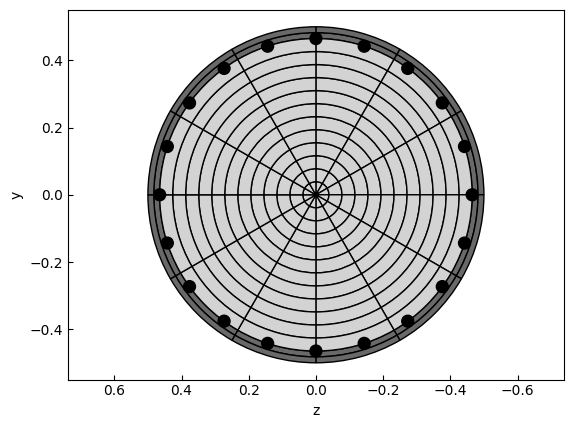

In [226]:
pier_ret = fiber_section(
    section_tag=1,
    diameter=1.0, cover=0.035,
    n_bars=20, rho_s=0.029,
    torsion_GJ=1.5e6,
    mat_core=mat_core, mat_cover=mat_cover, mat_steel=mat_steel,
    mesh_size=None, show_mesh=True, aucuracy_mesh=False
)

ops.section("Aggregator",2,mat_reverse,"T","-section",1)



#           截面类型   标签 弹性模量 面积 z惯性矩 y惯性矩 剪切模量 扭转惯性矩
ops.section("Elastic", 3,  2.5e7, 10.0, 8.0, 12.0, 9.6e6, 15.0)


## 构建element

In [227]:
def build_pier_elements_nonlin(pier_nodes: list,
                               secTag: int,
                               ele_tag_start: int = 1,
                               np: int = 5):
    """
    RC 墩柱：相邻节点两两连接为 nonlinearBeamColumn。
    几何变换在函数内定义：PDelta，参考向量 (0,1,0)。
    返回：下一个可用元素号。
    """

    # 定义/覆盖几何变换
    trans_tag = 1
    ops.geomTransf('PDelta', trans_tag, 0.0, 1.0, 0.0)

    # 定义 Radau 积分规则
    ops.beamIntegration('Radau', 1, secTag, np)

    eTag = int(ele_tag_start)
    for pier in pier_nodes:
        for col in pier:
            for i in range(len(col) - 1):
                ni, nj = col[i], col[i + 1]
                ops.element('forceBeamColumn', eTag, ni, nj, 1, trans_tag)
                eTag += 1
    return eTag


def build_deck_elements_elastic(deck_nodes: list,
                                A: float, E: float, G: float,
                                J: float, Iy: float, Iz: float,
                                ele_tag_start: int = 1000):
    """
    桥面梁：按中心线顺序连接为 elasticBeamColumn。
    几何变换在函数内定义：Linear，参考向量 (0,0,1)。
    返回：下一个可用元素号。
    """
    # 定义/覆盖几何变换
    trans_tag = 2
    ops.geomTransf('Linear', trans_tag, 0.0, 0.0, 1.0)

    # 串接所有跨的节点（生成时已避免跨界重复端点）
    chain = []
    for span in deck_nodes:
        chain.extend(span)

    eTag = int(ele_tag_start)
    for i in range(len(chain) - 1):
        ni, nj = chain[i], chain[i+1]
        ops.element('elasticBeamColumn', eTag, ni, nj,
                    A, E, G, J, Iy, Iz, trans_tag)
        eTag += 1
    return eTag

In [228]:
pier_ele = build_pier_elements_nonlin(
    pier_nodes=pier_res["pier_nodes"],
    secTag=2,      # 你的截面号（如纤维截面）
    ele_tag_start=1,
    np=7
)

deck_ele = build_deck_elements_elastic(
    deck_nodes=deck_res["deck_nodes"],
    A=2.0, E=3.0e10, G=1.2e10, J=0.20, Iy=0.15, Iz=0.30,
    ele_tag_start=1000
)

opsvis.plot_model(show_node_numbering=True)

## 构建横向刚性单元用于连接 桥墩-盖梁、桥主梁-桥台

In [229]:

def tie_piers_capbeam(pier_nodes, capbeam_nodes):
    """
    1. 将盖梁节点刚性连接到中心节点，模拟无限刚盖梁
    2. 将墩顶节点刚性连接到最近的盖梁节点

    pier_nodes[i][j][-1] 为第 i 个墩第 j 根柱的柱顶节点
    capbeam_nodes[i] 为第 i 个墩的盖梁节点列表
    处理：
      1) 识别每个墩的盖梁主节点：|y| 最小者
      2) 所有盖梁节点 rigidLink 到主节点
      3) 每根柱的柱顶节点 rigidLink 到最近的盖梁节点
    """
    for i, pier in enumerate(pier_nodes):
        cb = capbeam_nodes[i]
        cb_coord = {n: ops.nodeCoord(n) for n in cb}
        main = min(cb, key=lambda n: abs(cb_coord[n][1]))

        for n in cb:
            if n != main:
                ops.rigidLink('beam', main, n)

        for col in pier:
            top = col[-1]
            xt, yt, zt = ops.nodeCoord(top)
            nearest = min(cb, key=lambda n: (cb_coord[n][0]-xt)**2 + (cb_coord[n][1]-yt)**2 + (cb_coord[n][2]-zt)**2)
            ops.rigidLink('beam', nearest, top)



def rigidify_abutments(left_nodes: list[int], right_nodes: list[int]) -> dict:
    """
    将左右两端桥台顶节点各自用 rigidLink('beam', ...) 并为一个刚体。
    返回 {'left_master': tag, 'right_master': tag}
    """
    def _rigidify(group: list[int]) -> int:
        ys = [ops.nodeCoord(n)[1] for n in group]
        master = group[min(range(len(group)), key=lambda i: abs(ys[i]))]
        for n in group:
            if n != master:
                ops.rigidLink('beam', master, n)
        return master

    return {
        'left_master':  _rigidify(left_nodes),
        'right_master': _rigidify(right_nodes)
    }


tie_piers_capbeam(pier_res["pier_nodes"],capbeam_res["capbeam_nodes"])

# rigidify_abutments(abut_res["left"],abut_res["right"])

opsvis.plot_model(show_node_numbering=True)


## 处理连接节点

### 桥墩基础foundation

In [230]:
# -*- coding: utf-8 -*-
def set_foundation_linear_springs_min(
    pier_nodes,
    k_trans,                 # 长度=3: (Kx, Ky, Kz)
    k_rot,                   # 长度=3: (Kr_x, Kr_y, Kr_z)
    ele_tag_base,            # 第一个zeroLength元素号
    mat_tag_base,            # 第一个弹簧材料号（将占用连续6个号/根柱）
    ground_node_base         # 第一个“地基节点”号（每根柱占1个）
):
    ele_tag = int(ele_tag_base)
    mat_base = int(mat_tag_base)
    gnode   = int(ground_node_base)

    Kx, Ky, Kz = map(float, k_trans)
    Krx, Kry, Krz = map(float, k_rot)

    for span in pier_nodes:           # k
        for col_nodes in span:        # j
            base_node = int(col_nodes[0])  # 柱底节点（你已按约定把底部放在索引0）
            x, y, z = ops.nodeCoord(base_node)

            # 地基节点：与底节点同坐标并全固结
            ops.node(gnode, x, y, z)
            ops.fix(gnode, 1, 1, 1, 1, 1, 1)

            # 6个单轴线弹簧材料（平移1-3，转动4-6）
            mats = [mat_base + i for i in range(6)]
            ops.uniaxialMaterial('Elastic', mats[0], Kx)
            ops.uniaxialMaterial('Elastic', mats[1], Ky)
            ops.uniaxialMaterial('Elastic', mats[2], Kz)
            ops.uniaxialMaterial('Elastic', mats[3], Krx)
            ops.uniaxialMaterial('Elastic', mats[4], Kry)
            ops.uniaxialMaterial('Elastic', mats[5], Krz)

            # 零长度弹簧单元（6自由度）
            ops.element('zeroLength', ele_tag, base_node, gnode,
                        '-mat', *mats,
                        '-dir', 1, 2, 3, 4, 5, 6)

            # 递增到下一根柱
            ele_tag += 1      # 每根柱1个zeroLength
            mat_base += 6     # 每根柱占6个材料号
            gnode += 1        # 每根柱1个地基节点


k_trans = (274774.0045, 274774.0045, 0.0)          # (Kx, Ky, Kz)  kN/m
k_rot   = (1371958.6382, 1152445.2561, 0.0)        # (Kr_x, Kr_y, Kr_z)  kN·m/rad

set_foundation_linear_springs_min(
    pier_nodes=pier_res["pier_nodes"],
    k_trans=k_trans,
    k_rot=k_rot,
    ele_tag_base=1500,         # 你的zeroLength起始号
    mat_tag_base=2000,        # 你的材料起始号（每根柱占6个）
    ground_node_base=2500     # 你的地基节点起始号（每根柱1个）
)
opsvis.plot_model(show_node_numbering=True)

### 桥墩支座

In [231]:
def set_single_bearing(capbeam_center_nodes, deck_nodes, mat_tags, start_ele_tag=2000, tol=1e-6):
    """
    capbeam_center_nodes : 一维列表，每墩的盖梁中心节点
    deck_nodes           : 二维列表的主梁节点
    start_ele_tag        : 零长度单元起始号
    mat_tags             : (kx_tag, ky_tag, kz_tag)
    """
    deck_tags = [dn for row in deck_nodes for dn in row]
    deck_xyz = {dn: ops.nodeCoord(dn) for dn in deck_tags}

    ele = int(start_ele_tag)
    kx, ky, kz = mat_tags
    bearing_eles, mapping = [], []

    for cap_main in capbeam_center_nodes:
        xc, yc, zc = ops.nodeCoord(cap_main)
        deck_near = min(
            deck_tags,
            key=lambda dn: (deck_xyz[dn][0]-xc)**2 + (deck_xyz[dn][1]-yc)**2 + (deck_xyz[dn][2]-zc)**2
        )
        ops.element('zeroLength', ele, deck_near, cap_main,
                    '-mat', kx, ky, kz, '-dir', 1, 2, 3)
        bearing_eles.append(ele)
        mapping.append((cap_main, deck_near))
        ele += 1

    return {"bearing_eles": bearing_eles, "map": mapping}

    
bear_res = set_single_bearing(capbeam_res["capbeam_center_nodes"],deck_res["deck_nodes"],mat_tags=(4,5,6))
opsvis.plot_model(show_node_numbering=True)

### 桥台

In [232]:

def set_abutment(
    deck_nodes,
    start_node_tag,
    start_ele_tag,
    ssi_mat_tags, ssi_dirs,          # 桥台-地基：土弹簧
    bearing_mat_tags, bearing_dirs,  # 主梁-桥台：支座
    contact_mat_tags, contact_dirs,  # 主梁-桥台：碰撞/限位
    shearkey_mat_tags, shearkey_dirs,# 主梁-桥台：剪力键
    x_tol=1e-9
):
    # 识别首尾主梁节点：x最小和x最大；若同x取|y|最小
    tags = [n for row in deck_nodes for n in row]
    xyz  = {n: ops.nodeCoord(n) for n in tags}
    left  = min(tags, key=lambda n: (xyz[n][0],  abs(xyz[n][1])))
    right = max(tags, key=lambda n: (xyz[n][0], -abs(xyz[n][1])))


    tnode = int(start_node_tag)
    tele  = int(start_ele_tag)

    res = {
        "deck_end_nodes": {"left": left, "right": right},
        "abutment_nodes": {},     # 桥台节点
        "foundation_nodes": {},   # 地基节点
        "ssi_elements": [],       # 桥台-地基
        "bearing_elements": [],   # 主梁-桥台 支座
        "contact_elements": [],   # 主梁-桥台 碰撞
        "shearkey_elements": []   # 主梁-桥台 剪力键
    }

    for side, dn in (("left", left), ("right", right)):
        x, y, z = xyz[dn]

        abut = tnode; tnode += 1
        base = tnode; tnode += 1
        ops.node(abut, x, y, z)
        ops.node(base, x, y, z)
        ops.fix(base, 1, 1, 1, 1, 1, 1)

        # 桥台-地基：SSI
        ops.element('zeroLength', tele, abut, base,
                    '-mat', *ssi_mat_tags, '-dir', *ssi_dirs)
        res["ssi_elements"].append(tele); tele += 1

        # 主梁-桥台：支座
        ops.element('zeroLength', tele, dn, abut,
                    '-mat', *bearing_mat_tags, '-dir', *bearing_dirs)
        res["bearing_elements"].append(tele); tele += 1

        # 主梁-桥台：碰撞/限位
        ops.element('zeroLength', tele, dn, abut,
                    '-mat', *contact_mat_tags, '-dir', *contact_dirs)
        res["contact_elements"].append(tele); tele += 1

        # 主梁-桥台：剪力键
        ops.element('zeroLength', tele, dn, abut,
                    '-mat', *shearkey_mat_tags, '-dir', *shearkey_dirs)
        res["shearkey_elements"].append(tele); tele += 1

        res["abutment_nodes"][side] = abut
        res["foundation_nodes"][side] = base

    return res


abutment_res = set_abutment(deck_nodes = deck_res["deck_nodes"],
                            start_node_tag = 5000,
                            start_ele_tag  = 5000,
                            ssi_mat_tags = (7,), ssi_dirs = (1,),          # 桥台-地基：土弹簧
                            bearing_mat_tags = (4,5,6), bearing_dirs = (1,2,3),  # 主梁-桥台：支座
                            contact_mat_tags = (8,), contact_dirs = (1,),  # 主梁-桥台：碰撞/限位
                            shearkey_mat_tags = (9,), shearkey_dirs = (2,),# 主梁-桥台：剪力键
                            x_tol=1e-9
                            )

opsvis.plot_model(show_node_numbering=True)